# Supervised HMM segmentation

## Init

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
import datetime as dt
from scipy import signal
import os
from pathlib import Path

In [2]:
from segmentation_utils import (
    extract_eef_data_from_rosbag,
    get_ground_truth_segmentation,
)

In [3]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS

# pyro.set_rng_seed(1)

In [4]:
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

## Data files

In [5]:
data_path_root = Path("../../table-task-ur5e")
data_path_root.exists()

True

In [6]:
bagfiles = list(data_path_root.glob("*.bag"))
bagfiles

[PosixPath('../../table-task-ur5e/rosbag2_2025-08-05_21-08-23_2025-08-05-21-08-23.bag'),
 PosixPath('../../table-task-ur5e/rosbag2_2025-08-05_21-33-31_2025-08-05-21-33-31.bag'),
 PosixPath('../../table-task-ur5e/rosbag2_2025-08-05_21-36-29_2025-08-05-21-36-29.bag'),
 PosixPath('../../table-task-ur5e/rosbag2_2025-08-05_21-43-41_2025-08-05-21-43-41.bag'),
 PosixPath('../../table-task-ur5e/rosbag2_2025-09-04_18-10-23_2025-09-04-18-10-23_test-image.bag'),
 PosixPath('../../table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('../../table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('../../table-task-ur5e/rosbag2_2025-09-08_16-53-14_2025-09-08-16-53-14_okayish.bag'),
 PosixPath('../../table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('../../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [7]:
filenum = -1
bagfile = bagfiles[filenum]
bagfile

PosixPath('../../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')

In [8]:
ground_truth_segm_file = data_path_root / "table_task_UR5e_ground_truth.json"
ground_truth_segm_file.exists()

True

## Preprocessing

In [9]:
traj = extract_eef_data_from_rosbag(bagfile)
traj

Extracting TF & gripper data from Bag file...


  0%|          | 0/183488 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓


,x,y,z,timestamp,gripper
0,-0.057518,-0.349359,0.245916,2025-09-08 18:46:19.430824291-05:00,0.01
1,-0.057527,-0.349371,0.245943,2025-09-08 18:46:19.432620296-05:00,0.01
2,-0.057521,-0.349371,0.245940,2025-09-08 18:46:19.434438816-05:00,0.01
3,-0.057525,-0.349373,0.245945,2025-09-08 18:46:19.436862995-05:00,0.01
4,-0.057515,-0.349382,0.245951,2025-09-08 18:46:19.438580443-05:00,0.01
...,...,...,...,...,...
57561,-0.079063,-0.339990,0.226383,2025-09-08 18:48:14.634462638-05:00,0.01
57562,-0.079040,-0.339984,0.226385,2025-09-08 18:48:14.636379567-05:00,0.01
57563,-0.079073,-0.339983,0.226388,2025-09-08 18:48:14.638744970-05:00,0.01
57564,-0.079063,-0.339978,0.226381,2025-09-08 18:48:14.640788775-05:00,0.01


In [10]:
df = traj.diff().mean().timestamp.total_seconds()
df

0.002001

In [11]:
# downsampling = 10

In [12]:
# freq = 1 / (df * downsampling)
# freq

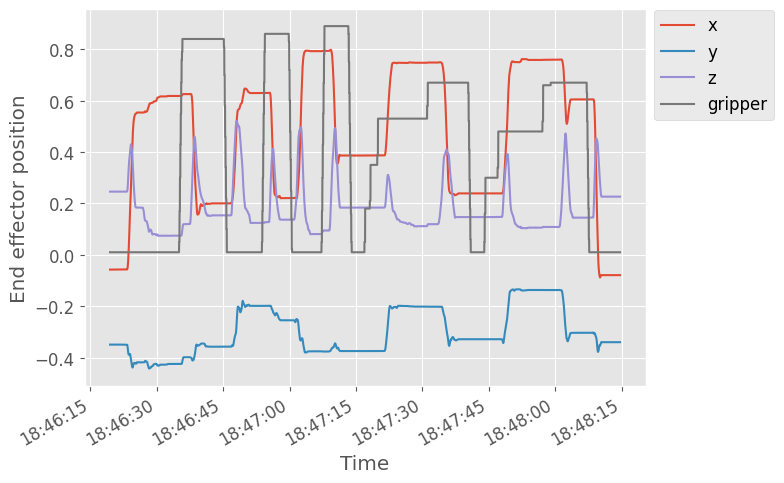

In [13]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(8, 5))
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Ground truth segmentation

In [14]:
gt_segm_dict = get_ground_truth_segmentation(
    ground_truth_segm_file=ground_truth_segm_file, bagfile=bagfile
)
gt_segm_dict

{'filename': 'rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag',
 'HigherLevel': {'plate': {'ini': 1757375183, 'end': 1757375205},
  'cup': {'ini': 1757375207, 'end': 1757375220},
  'napkin': {'ini': 1757375220, 'end': 1757375232},
  'spoon': {'ini': 1757375235, 'end': 1757375258},
  'fork': {'ini': 1757375262, 'end': 1757375288}},
 'LowerLevel': {'reaching': [{'ini': 1757375183, 'end': 1757375194},
   {'ini': 1757375207, 'end': 1757375212},
   {'ini': 1757375220, 'end': 1757375226},
   {'ini': 1757375235, 'end': 1757375253},
   {'ini': 1757375262, 'end': 1757375280}],
  'placing': [{'ini': 1757375197, 'end': 1757375205},
   {'ini': 1757375215, 'end': 1757375220},
   {'ini': 1757375228, 'end': 1757375232},
   {'ini': 1757375253, 'end': 1757375258},
   {'ini': 1757375280, 'end': 1757375288}]}}

### Higher level movements

In [15]:
# with plt.style.context("ggplot_perso.mplstyle"):
#     fig, ax = plt.subplots(figsize=(11, 7))
#     cmap = mpl.colormaps.get("Pastel2").colors
#     ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
#     ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
#     ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
#     ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])

#     fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
#     fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
#     for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
#         sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
#         xs = traj.timestamp[
#             (
#                 traj.timestamp
#                 > pd.Timestamp(
#                     dt.datetime.fromtimestamp(sect_dict_current["ini"])
#                     - dt.timedelta(hours=1),
#                     tz="EST",
#                 )
#             )
#             & (
#                 traj.timestamp
#                 < pd.Timestamp(
#                     dt.datetime.fromtimestamp(sect_dict_current["end"])
#                     - dt.timedelta(hours=1),
#                     tz="EST",
#                 )
#             )
#         ]  # - dt.timedelta(hours=5)
#         ax.fill_between(
#             x=xs,
#             y1=fill_min - 1,
#             y2=fill_max + 1,
#             color=cmap[sect_i],
#             alpha=0.5,
#             transform=ax.get_xaxis_transform(),
#             label=sect_key,
#         )

#     ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
#     ax.set_xlabel("Time")
#     ax.set_ylabel("End effector position")
#     ax.legend(bbox_to_anchor=(1.0, 1.02))
#     ax.set_title("Ground truth clustering")
#     fig.autofmt_xdate()
#     fig.tight_layout()
#     plt.show()

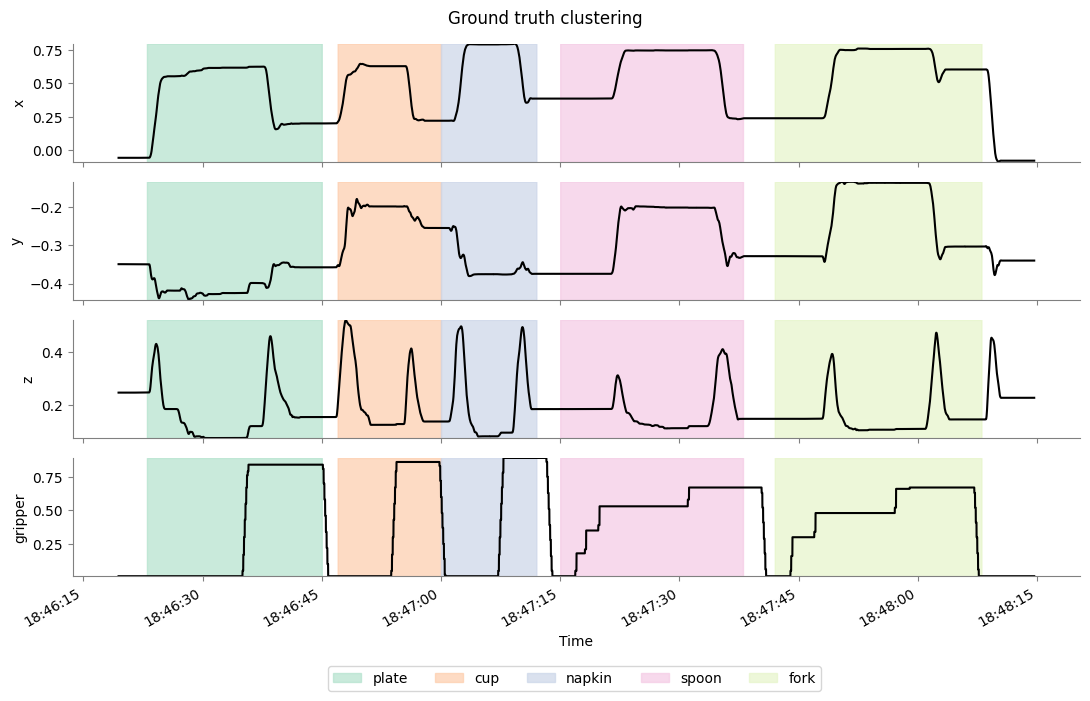

In [59]:
df_labels = list(traj.drop(columns=["timestamp"]).keys())
fig, axes = plt.subplots(
    nrows=len(df_labels), ncols=1, sharex=True, sharey=False, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
for idx, ax in enumerate(axes):
    ax.plot(traj.timestamp, traj[df_labels[idx]], "k")
    ax.set_ylabel(df_labels[idx])
    ax.spines[["right", "top"]].set_visible(False)

    y_low = traj[df_labels[idx]].min()
    y_high = traj[df_labels[idx]].max()
    ax.set_ylim(bottom=y_low, top=y_high)
    ax.tick_params(color='gray')
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

    for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
        sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
        xs = traj.timestamp[
            (
                traj.timestamp
                > pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["ini"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
            & (
                traj.timestamp
                < pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["end"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
        ]  # - dt.timedelta(hours=5)
        ax.fill_between(
            x=xs,
            y1=y_low,
            y2=y_high,
            color=cmap[sect_i],
            alpha=0.7,
            # transform=ax.get_xaxis_transform(),
            label=sect_key,
        )

axes[-1].set_xlabel("Time")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
axes[-1].legend(bbox_to_anchor=(0.75, -0.7), ncol=len(gt_segm_dict["HigherLevel"].keys()))
fig.suptitle("Ground truth clustering")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

### Lower level movements

In [17]:
# with plt.style.context("ggplot_perso.mplstyle"):
#     fig, ax = plt.subplots(figsize=(11, 7))
#     cmap = mpl.colormaps.get("Pastel2").colors
#     ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
#     ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
#     ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
#     ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])

#     fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
#     fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
#     for sect_i, sect_key in enumerate(gt_segm_dict["LowerLevel"].keys()):
#         skill_current = gt_segm_dict["LowerLevel"][sect_key]
#         for skill_i, skill_val in enumerate(skill_current):
#             xs = traj.timestamp[
#                 (
#                     traj.timestamp
#                     > pd.Timestamp(
#                         dt.datetime.fromtimestamp(skill_val["ini"])
#                         - dt.timedelta(hours=1),
#                         tz="EST",
#                     )
#                 )
#                 & (
#                     traj.timestamp
#                     < pd.Timestamp(
#                         dt.datetime.fromtimestamp(skill_val["end"])
#                         - dt.timedelta(hours=1),
#                         tz="EST",
#                     )
#                 )
#             ]  # - dt.timedelta(hours=5)
#             if skill_i == 0:
#                 ax.fill_between(
#                     x=xs,
#                     y1=fill_min - 1,
#                     y2=fill_max + 1,
#                     color=cmap[sect_i],
#                     alpha=0.5,
#                     transform=ax.get_xaxis_transform(),
#                     label=sect_key,
#                 )
#             else:
#                 ax.fill_between(
#                     x=xs,
#                     y1=fill_min - 1,
#                     y2=fill_max + 1,
#                     color=cmap[sect_i],
#                     alpha=0.5,
#                     transform=ax.get_xaxis_transform(),
#                     # label=sect_key,
#                 )

#     ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
#     ax.set_xlabel("Time")
#     ax.set_ylabel("End effector position")
#     ax.legend(bbox_to_anchor=(1.0, 1.02))
#     ax.set_title("Ground truth clustering")
#     fig.autofmt_xdate()
#     fig.tight_layout()
#     plt.show()

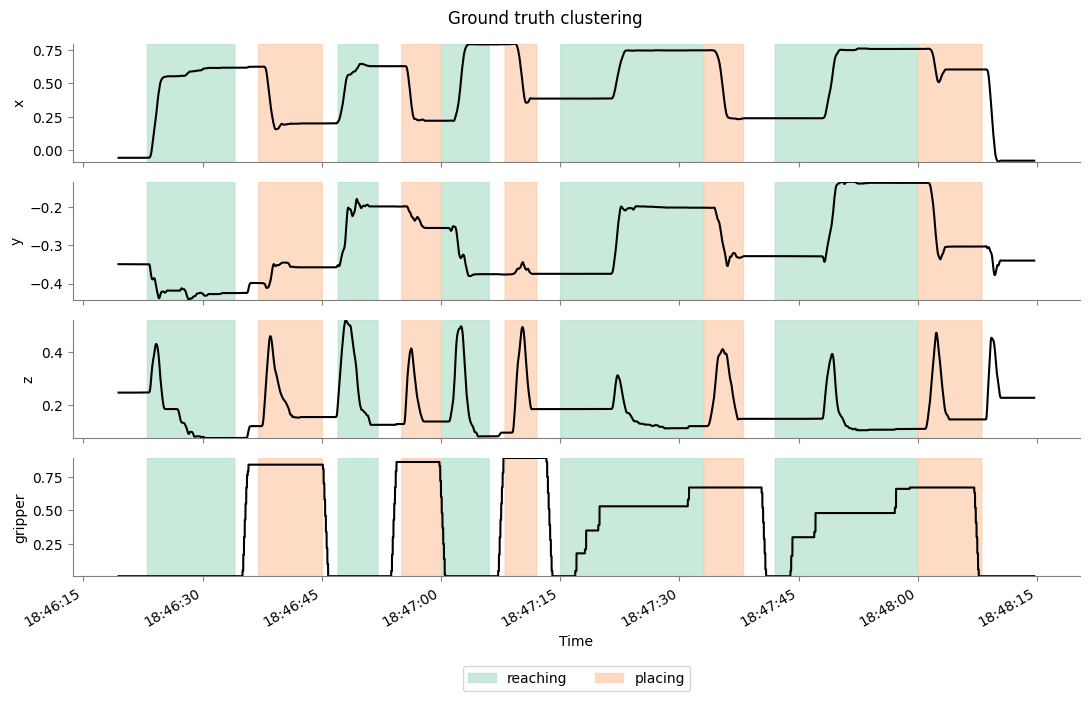

In [62]:
df_labels = list(traj.drop(columns=["timestamp"]).keys())
fig, axes = plt.subplots(
    nrows=len(df_labels), ncols=1, sharex=True, sharey=False, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
for idx, ax in enumerate(axes):
    ax.plot(traj.timestamp, traj[df_labels[idx]], "k")
    ax.set_ylabel(df_labels[idx])
    ax.spines[["right", "top"]].set_visible(False)

    y_low = traj[df_labels[idx]].min()
    y_high = traj[df_labels[idx]].max()
    ax.set_ylim(bottom=y_low, top=y_high)
    ax.tick_params(color='gray')
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

    for sect_i, sect_key in enumerate(gt_segm_dict["LowerLevel"].keys()):
        skill_current = gt_segm_dict["LowerLevel"][sect_key]
        for skill_i, skill_val in enumerate(skill_current):
            xs = traj.timestamp[
                (
                    traj.timestamp
                    > pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["ini"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
                & (
                    traj.timestamp
                    < pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["end"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
            ]  # - dt.timedelta(hours=5)
            if skill_i == 0:
                ax.fill_between(
                    x=xs,
                    y1=y_low,
                    y2=y_high,
                    color=cmap[sect_i],
                    alpha=0.7,
                    # transform=ax.get_xaxis_transform(),
                    label=sect_key,
                )
            else:
                ax.fill_between(
                    x=xs,
                    y1=y_low,
                    y2=y_high,
                    color=cmap[sect_i],
                    alpha=0.7,
                    # transform=ax.get_xaxis_transform(),
                )

axes[-1].set_xlabel("Time")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
axes[-1].legend(bbox_to_anchor=(0.62, -0.7), ncol=len(gt_segm_dict["LowerLevel"].keys()))
fig.suptitle("Ground truth clustering")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

## Segmentation

### Preprocessing

In [19]:
downsampling_factor = 200

In [20]:
# true_cps = np.ones((len(gt_segm_dict["HigherLevel"]) - 1)) * np.nan
# for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
#     sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
#     if sect_i < len(true_cps):
#         true_cps[sect_i] = sect_dict_current["end"]
# true_cps

In [21]:
# what_segments = "HigherLevel"
what_segments = "LowerLevel"

labels = gt_segm_dict[what_segments].keys()
labels

dict_keys(['reaching', 'placing'])

In [22]:
X = traj.drop(columns=["timestamp"])
X

,x,y,z,gripper
0,-0.057518,-0.349359,0.245916,0.01
1,-0.057527,-0.349371,0.245943,0.01
2,-0.057521,-0.349371,0.245940,0.01
3,-0.057525,-0.349373,0.245945,0.01
4,-0.057515,-0.349382,0.245951,0.01
...,...,...,...,...
57561,-0.079063,-0.339990,0.226383,0.01
57562,-0.079040,-0.339984,0.226385,0.01
57563,-0.079073,-0.339983,0.226388,0.01
57564,-0.079063,-0.339978,0.226381,0.01


In [23]:
def get_closest_ts(traj_ts, query_idx):
    idx2ts = pd.Timestamp(
        dt.datetime.fromtimestamp(query_idx) - dt.timedelta(hours=1),
        tz="EST",
    )
    closest_tdelta = (traj_ts - idx2ts).abs().min()
    idx_res = traj_ts.index[traj_ts == closest_tdelta + idx2ts]
    return idx_res[0]

In [24]:
# Create supervised labels
y = np.ones(shape=X.shape[0]) * np.nan
if what_segments == "HigherLevel":
    for sect_i, sect_key in enumerate(gt_segm_dict[what_segments].keys()):
        sect_dict_current = gt_segm_dict[what_segments][sect_key]
        idx_ini = get_closest_ts(
            traj_ts=traj.timestamp, query_idx=sect_dict_current["ini"]
        )
        idx_end = get_closest_ts(
            traj_ts=traj.timestamp, query_idx=sect_dict_current["end"]
        )
        y[idx_ini:idx_end] = sect_i

elif what_segments == "LowerLevel":
    for sect_i, sect_key in enumerate(gt_segm_dict[what_segments].keys()):
        skill_current = gt_segm_dict[what_segments][sect_key]
        for skill_i, skill_val in enumerate(skill_current):
            idx_ini = get_closest_ts(traj_ts=traj.timestamp, query_idx=skill_val["ini"])
            idx_end = get_closest_ts(traj_ts=traj.timestamp, query_idx=skill_val["end"])
            y[idx_ini:idx_end] = sect_i

else:
    raise ValueError("what_segments can only be 'HigherLevel' or 'LowerLevel'")
y

array([nan, nan, nan, ..., nan, nan, nan], shape=(57566,))

In [25]:
np.unique(y)

array([ 0.,  1., nan])

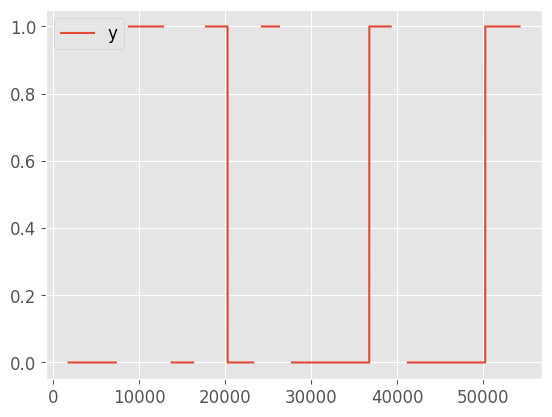

In [26]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y, label="y")
    ax.legend(loc="best")
    plt.show()

In [27]:
idx2filter = np.where(~np.isnan(y))
idx2filter

(array([ 1785,  1786,  1787, ..., 54243, 54244, 54245], shape=(43966,)),)

In [28]:
y_filtered = y[idx2filter]
y_filtered

array([0., 0., 0., ..., 1., 1., 1.], shape=(43966,))

In [29]:
np.unique(y_filtered)

array([0., 1.])

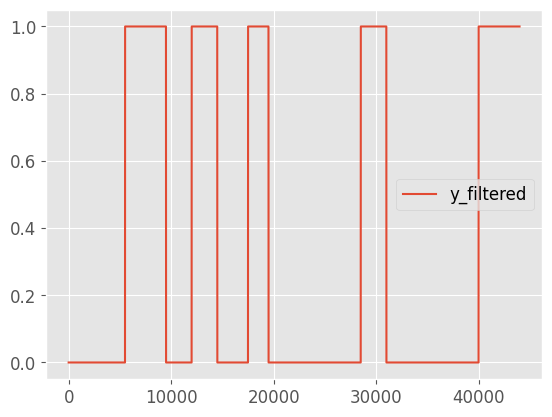

In [30]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y_filtered, label="y_filtered")
    ax.legend(loc="best")
    plt.show()

In [31]:
X_filtered = X.iloc[idx2filter]
X_filtered

,x,y,z,gripper
1785,-0.057529,-0.349365,0.245910,0.01
1786,-0.057517,-0.349362,0.245916,0.01
1787,-0.057519,-0.349371,0.245965,0.01
1788,-0.057496,-0.349364,0.245927,0.01
1789,-0.057527,-0.349372,0.245934,0.01
...,...,...,...,...
54241,0.604773,-0.303366,0.144645,0.01
54242,0.604773,-0.303355,0.144652,0.01
54243,0.604772,-0.303351,0.144637,0.01
54244,0.604767,-0.303379,0.144689,0.01


In [32]:
X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_filtered)
X_scaled

array([[2.03462542e-05, 3.02970248e-01, 3.84556711e-01, 0.00000000e+00],
       [3.37339936e-05, 3.02978356e-01, 3.84570559e-01, 0.00000000e+00],
       [3.12934476e-05, 3.02949718e-01, 3.84679761e-01, 0.00000000e+00],
       ...,
       [7.73938439e-01, 4.52026190e-01, 1.57855692e-01, 0.00000000e+00],
       [7.73931971e-01, 4.51937085e-01, 1.57972680e-01, 0.00000000e+00],
       [7.73951043e-01, 4.51959832e-01, 1.57998140e-01, 0.00000000e+00]],
      shape=(43966, 4))

In [33]:
X_down = signal.decimate(x=X_filtered, q=downsampling_factor, axis=0)
X_down.shape

(220, 4)

In [34]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))
X_down_scaled = minmaxscaler.fit_transform(X_down)
X_down_scaled.shape

(220, 4)

In [35]:
np.any(np.isinf(X_down_scaled)), np.any(np.isnan(X_down_scaled))

(np.False_, np.False_)

In [36]:
y_down = np.round(signal.decimate(x=y_filtered, q=downsampling_factor, axis=0)).astype(int)
y_down

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [37]:
np.unique(y_down)

array([0, 1])

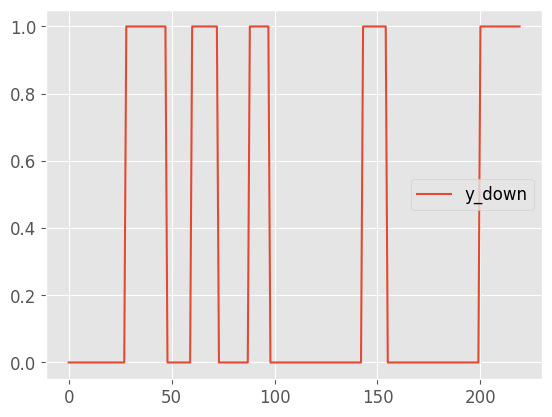

In [38]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y_down, label="y_down")
    ax.legend(loc="best")
    plt.show()

In [39]:
# timestamp_down = traj.timestamp[
#     np.arange(start=traj.index.start, stop=traj.index.stop, step=downsampling_factor)
# ]
# timestamp_down

### Supervised HMM

In [40]:
supervised_classes = torch.tensor(y_down, dtype=int)
supervised_observations = torch.tensor(X_down_scaled)

In [41]:
supervised_classes.shape, supervised_observations.shape

(torch.Size([220]), torch.Size([220, 4]))

In [42]:
supervised_classes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])

In [43]:
# pyro.set_rng_seed(1)

num_hidden_states = len(labels)  # number of hidden states
num_features = X.shape[1]  # number of continuous features

# Priors for transition probabilities
transition_prior = torch.empty(num_hidden_states).fill_(1.0)

# Sample transition probabilities
transition_prob = dist.Dirichlet(transition_prior).sample(
    torch.Size([num_hidden_states])
)

In [44]:
def equilibrium(mc_matrix):
    """
    Calculate the equilibrium distribution of a Markov chain.
    Returns a 1D tensor of probabilities.
    """
    n = mc_matrix.size(0)
    # Create a system of linear equations
    A = torch.eye(n, dtype=float) - mc_matrix.t() + 1
    b = torch.ones(n, dtype=float)
    # Solve for equilibrium distribution
    equilibrium_dist = torch.linalg.solve(A, b)
    # Normalize to ensure it's a valid probability distribution
    equilibrium_dist = equilibrium_dist / equilibrium_dist.sum()
    return equilibrium_dist

In [66]:
start_prob = equilibrium(transition_prob)
start_prob

tensor([0.6256, 0.3744], dtype=torch.float64)

In [46]:
def supervised_hmm_continuous(classes, observations):
    num_timesteps = len(observations)

    with pyro.plate("prob_plate", num_hidden_states):
        transition_prob = pyro.sample(
            "transition_prob", dist.Dirichlet(transition_prior)
        )

        # Sample emission parameters for each state
        emission_locs = pyro.sample(
            "emission_locs",
            dist.Normal(0, 5).expand([num_hidden_states, num_features]).to_event(2),
        )

        # Use diagonal covariance for simplicity
        emission_scales = pyro.sample(
            "emission_scales",
            dist.LogNormal(0, 1).expand([num_hidden_states, num_features]).to_event(2),
        )

    class_id = classes[0]
    for t in range(num_timesteps):
        if t > 0:
            class_id = pyro.sample(
                f"class_id_{t}",
                dist.Categorical(transition_prob[class_id]),
                obs=classes[t],
            )

        # Emit continuous observation
        pyro.sample(
            f"obs_{t}",
            dist.Normal(emission_locs[class_id], emission_scales[class_id]).to_event(1),
            obs=observations[t],
        )

In [47]:
# pyro.render_model(
#     supervised_hmm_continuous,
#     model_kwargs=[
#         {"classes": supervised_classes, "observations": supervised_observations},
#     ],
#     render_params=True,
#     render_distributions=True,
#     render_deterministic=True,
# )

In [48]:
nuts_kernel = NUTS(
    supervised_hmm_continuous, jit_compile=True, ignore_jit_warnings=True
)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50)
mcmc.run(classes=supervised_classes, observations=supervised_observations)

Sample: 100%|██████████████████████████| 150/150 [08:34,  3.43s/it, step size=3.60e-02, acc. prob=0.904]


In [49]:
mcmc.summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
  emission_locs[0,0,0]      0.73      0.02      0.73      0.70      0.76     94.68      1.00
  emission_locs[0,0,1]      0.50      0.03      0.50      0.47      0.55    122.36      0.99
  emission_locs[0,0,2]      0.22      0.02      0.22      0.18      0.24    144.92      0.99
  emission_locs[0,0,3]      0.33      0.02      0.32      0.27      0.35    123.89      0.99
  emission_locs[0,1,0]      0.72      0.02      0.72      0.69      0.75     76.00      1.01
  emission_locs[0,1,1]      0.51      0.03      0.51      0.47      0.56     54.00      0.99
  emission_locs[0,1,2]      0.22      0.02      0.22      0.19      0.25     32.90      1.00
  emission_locs[0,1,3]      0.33      0.02      0.33      0.30      0.35    101.29      1.01
  emission_locs[1,0,0]      0.60      0.03      0.60      0.55      0.65     58.39      1.07
  emission_locs[1,0,1]      0.45      0.02      0.45      0.42      0

In [50]:
# Get samples
samples = mcmc.get_samples()
print("Posterior transition_prob shape:", samples["transition_prob"].shape)
print("Posterior emission_locs shape:", samples["emission_locs"].shape)
print("Posterior emission_scales shape:", samples["emission_scales"].shape)

Posterior transition_prob shape: torch.Size([100, 2, 2])
Posterior emission_locs shape: torch.Size([100, 2, 2, 4])
Posterior emission_scales shape: torch.Size([100, 2, 2, 4])


In [51]:
samples.keys()

dict_keys(['emission_locs', 'emission_scales', 'transition_prob'])

In [52]:
def viterbi_continuous(observations, transition_prob, emission_locs, emission_scales):
    """
    Viterbi algorithm for continuous emissions.

    Args:
        observations: [num_timesteps, num_features]
        transition_prob: [num_hidden_states, num_hidden_states]
        emission_locs: [num_hidden_states, num_features]
        emission_scales: [num_hidden_states, num_features]
    """
    num_timesteps = len(observations)
    num_states = transition_prob.size(0)

    # Initialize
    viterbi_prob = torch.zeros(num_timesteps, num_states)
    viterbi_path = torch.zeros(num_timesteps, num_states, dtype=torch.long)

    # Start probability
    start_prob = equilibrium(transition_prob)

    # Helper function to compute emission log probabilities for all states
    def compute_emission_log_probs(obs):
        """Compute log P(obs | state) for all states."""
        # obs: [num_features]
        # emission_locs: [num_states, num_features]
        # Returns: [num_states]
        log_probs = torch.zeros(num_states)
        for s in range(num_states):
            # Compute log probability under Normal(emission_locs[s], emission_scales[s])
            diff = obs - emission_locs[s]
            log_prob = -0.5 * ((diff / emission_scales[s]) ** 2).sum()
            log_prob = log_prob - emission_scales[s].log().sum()
            log_prob = log_prob - 0.5 * len(obs) * torch.log(
                torch.tensor(2 * 3.14159265)
            )
            log_probs[s] = log_prob
        return log_probs

    # Initial step
    viterbi_prob[0] = start_prob.log() + compute_emission_log_probs(observations[0])

    # Forward pass
    for t in range(1, num_timesteps):
        emission_log_prob = compute_emission_log_probs(observations[t])

        for s in range(num_states):
            trans_probs = viterbi_prob[t - 1] + transition_prob[:, s].log()
            viterbi_path[t, s] = trans_probs.argmax()
            viterbi_prob[t, s] = trans_probs.max() + emission_log_prob[s]

    # Backtrack
    most_likely_states = torch.zeros(num_timesteps, dtype=torch.long)
    most_likely_states[-1] = viterbi_prob[-1].argmax()

    for t in range(num_timesteps - 2, -1, -1):
        most_likely_states[t] = viterbi_path[t + 1, most_likely_states[t + 1]]

    return most_likely_states

In [53]:
# Get posterior means
mean_transition_prob = samples["transition_prob"].mean(dim=0)
mean_emission_locs = samples["emission_locs"].mean(dim=0)
mean_emission_scales = samples["emission_scales"].mean(dim=0)

In [54]:
# Now run prediction
predicted_states = viterbi_continuous(
    observations=supervised_observations,
    transition_prob=mean_transition_prob,
    emission_locs=mean_emission_locs,
    emission_scales=mean_emission_scales,
)

print(f"True classes:\n{supervised_classes}")
print(f"Predicted hidden states:\n{predicted_states}")
print(f"State distribution: {torch.bincount(predicted_states)}")

True classes:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
Predicted hidden states:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1

### Metrics & visualization

In [55]:
accu = accuracy_score(y_true=supervised_classes, y_pred=predicted_states)
f1 = f1_score(y_true=supervised_classes, y_pred=predicted_states, average="macro")
print(f"Accuracy: {accu}")
print(f"F1: {f1}")

Accuracy: 0.9590909090909091
F1: 0.9543347401923477


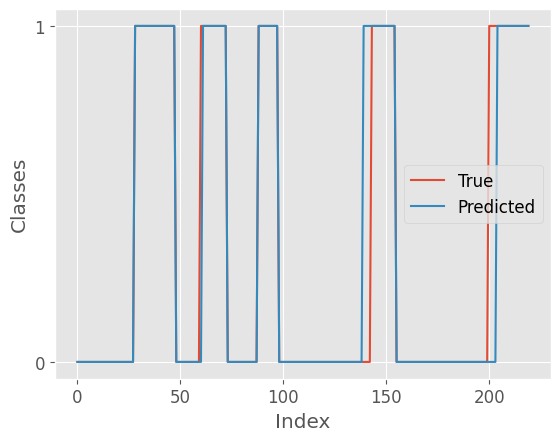

In [56]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(supervised_classes, label="True")
    ax.plot(predicted_states, label="Predicted")
    ax.legend(loc="best")
    ax.set_ylabel("Classes")
    ax.set_xlabel("Index")
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(supervised_classes.unique()))
    ax.yaxis.set_major_formatter(mpl.ticker.FixedFormatter([str(elem.item()) for elem in supervised_classes.unique()]))
    plt.show()

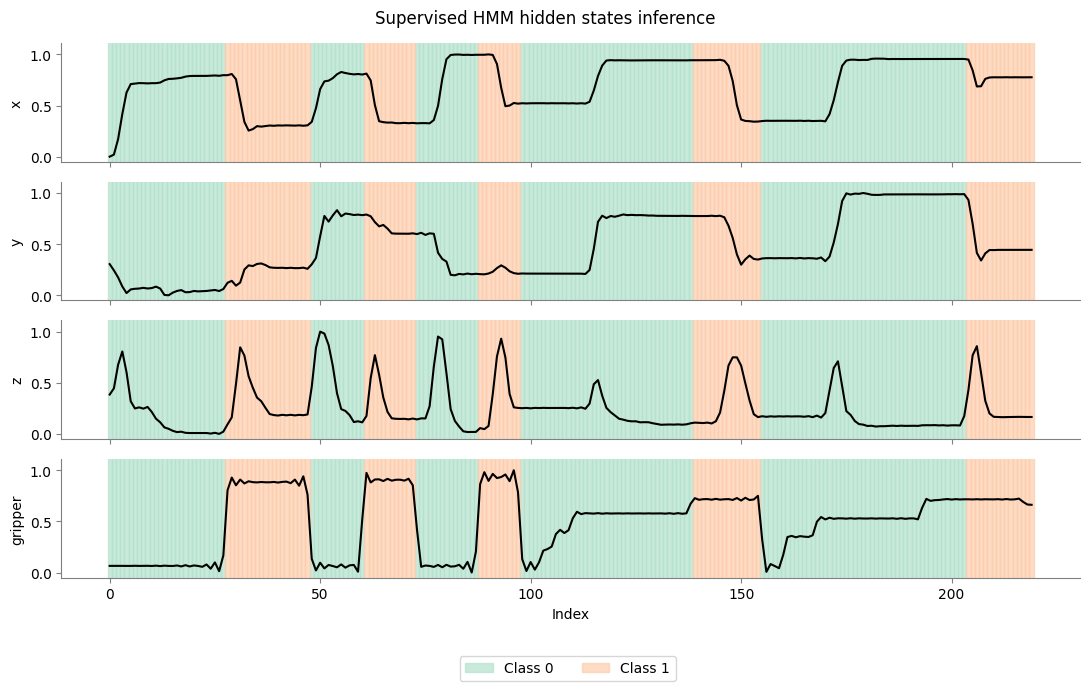

In [65]:
fig, axes = plt.subplots(
    nrows=supervised_observations.shape[1], ncols=1, sharex=True, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
labels = list(traj.drop(columns=["timestamp"]).keys())
ts = torch.arange(end=supervised_observations.shape[0])
for idx, ax in enumerate(axes):
    ax.plot(supervised_observations[:, idx], "k")  # , color=cmap[0])
    ax.set_ylabel(labels[idx])
    ax.spines[["right", "top"]].set_visible(False)
    ax.tick_params(color='gray')
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

    # fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
    # fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
    #     ax.fill_between(
    #         x=xs,
    #         y1=fill_min - 1,
    #         y2=fill_max + 1,
    #         color=cmap[sect_i],
    #         alpha=0.5,
    #         transform=ax.get_xaxis_transform(),
    #         label=sect_key,
    #     )
    y_low, y_high = ax.get_ylim()
    y_mid = torch.tensor([y_low, y_high]).mean().item()
    # y_height = 0.05 * (y_high - y_low)
    y_height = y_high - y_low
    for jdx, class_id in enumerate(supervised_classes.unique()):
        xs = ts[predicted_states == class_id]
        for zdx, xi in enumerate(xs):
            if zdx == 0:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                    label=f"Class {class_id}",
                )
            else:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                )
    ax.set_ylim(bottom=y_low * 1.01, top=y_height * 1.01)
axes[-1].set_xlabel("Index")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
axes[-1].legend(bbox_to_anchor=(0.61, -0.6), ncol=len(supervised_classes.unique()))
fig.suptitle("Supervised HMM hidden states inference")
# fig.autofmt_xdate()
fig.tight_layout()
plt.show()